In [39]:
import pandas as pd
import numpy as np

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

train.shape, test.shape, sample_sub.shape

((96294, 15), (64197, 14), (64197, 2))

In [41]:
target = train['대출등급']
target

0        C
1        B
2        A
3        C
4        B
        ..
96289    C
96290    E
96291    A
96292    D
96293    C
Name: 대출등급, Length: 96294, dtype: object

In [42]:
train_ft = train.iloc[:,1:-1].copy()
test_ft = test.iloc[:,1:].copy()

train_ft.shape, test_ft.shape

((96294, 13), (64197, 13))

In [43]:
train_ft['근로기간'].value_counts()

근로기간
10+ years    31585
2 years       8450
< 1 year      7774
3 years       7581
1 year        6249
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
10+years       896
<1 year        370
3               89
1 years         56
Name: count, dtype: int64

In [ ]:
train_ft.loc[train_ft['근로기간']=='3','근로기간']='3 years'
test_ft.loc[test_ft['근로기간']=='3','근로기간']='3 years'
test_ft.loc[test_ft['근로기간']=='1 year','근로기간']='1 years'
train_ft.loc[train_ft['근로기간']=='1 year','근로기간']='1 years'
test_ft.loc[test_ft['근로기간']=='<1 year','근로기간']='< 1 year'
train_ft.loc[train_ft['근로기간']=='<1 year','근로기간']='< 1 year'
test_ft.loc[test_ft['근로기간']=='10+years','근로기간']='10+ years'
train_ft.loc[train_ft['근로기간']=='10+years','근로기간']='10+ years'

In [7]:
근로기간_dict = {
    "Unknown": 1,
    "u_1_year": 1.5,
    "1_year": 2,
    "2_years": 3,
    "3_years": 4,
    "4_years": 5,
    "5_years": 6,
    "6_years": 7,
    "7_years": 8,
    "8_years": 9,
    "9_years": 10,
    "10p_years": 11
}

# '근로기간' 열을 숫자로 변환하여 새로운 열 '근로기간 숫자'를 생성
train_ft['근로기간_숫자'] = train_ft['근로기간'].map(근로기간_dict)
test_ft['근로기간_숫자'] = test_ft['근로기간'].map(근로기간_dict)

In [8]:
train_ft['근로기간'].value_counts()

근로기간
10p_years    32481
2_years       8450
u_1_year      8144
3_years       7670
1_year        6305
Unknown       5671
5_years       5665
4_years       5588
8_years       4888
6_years       3874
7_years       3814
9_years       3744
Name: count, dtype: int64

In [9]:
train_ft['대출기간_숫자'] = train_ft['대출기간'].str.extract('(\d+)').astype(int)
test_ft['대출기간_숫자'] = test_ft['대출기간'].str.extract('(\d+)').astype(int)

In [10]:
# train_ft['총상환금'] = train_ft['총상환원금']+train_ft['총상환이자']
# test_ft['총상환금'] = test_ft['총상환원금']+test_ft['총상환이자']

In [11]:
train_ft['주택소유상태'] = train_ft['주택소유상태'].replace('ANY','MORTGAGE')
train_ft['주택소유상태'].value_counts()

주택소유상태
MORTGAGE    47935
RENT        37705
OWN         10654
Name: count, dtype: int64

In [12]:
q1,q3 = train_ft['대출금액'].quantile([0.25,0.75])
iqr = q3 - q1
w = 1.5
box_min = q1 - iqr * w
box_max = q1 + iqr * w

def boxplot(x):
    if x < box_min or x >= box_max:
        return 0 # x가 이상치의 경우에는 0으로 설정해준다.
    elif box_min <= x < q1:
        return 1  # x가 Q1보다 크거나 같고 Q1보다 작은 경우
    elif q1 <= x < q3:
        return 2  # x가 Q1 이상이고 Q3 미만인 경우
    elif q3 <= x < box_max:
        return 3  # x가 Q3 이상이고 box_max 미만인 경우
    else:
        return 'Undefined'

train_ft['대출금액_분위수'] = train_ft['대출금액'].apply(boxplot)
test_ft['대출금액_분위수'] = test_ft['대출금액'].apply(boxplot)

In [13]:
train_ft['총상환이자대비연간소득'] = train_ft.apply(lambda x: x['연간소득'] / x['총상환이자'] if x['총상환이자'] > 0 else float('nan'), axis=1)
train_ft['총상환원금대비연간소득'] = train_ft.apply(lambda x: x['연간소득'] / x['총상환원금'] if x['총상환원금'] > 0 else float('nan'), axis=1)
train_ft['총상환원금_대비_총연체금액'] = train_ft.apply(lambda x: x['총연체금액'] / (x['총상환원금']+ x['총상환이자']) if (x['총상환원금']+ x['총상환이자']) > 0 else float('nan'), axis=1)
train_ft['상환_대비_이자_비율'] = train_ft.apply(lambda x: x['총상환이자'] / x['총상환원금'] if x['총상환원금'] > 0 else float('nan'), axis=1)
train_ft['연소득_대비_총상환금'] = train_ft.apply(lambda x: (x['총상환원금']+ x['총상환이자'])/ x['연간소득'] if x['연간소득'] > 0 else float('nan'), axis=1)
train_ft['총계좌수대비연간소득'] = train_ft['연간소득']/train_ft['총계좌수']
train_ft['총상환원금_대비_대출금액비율'] = train_ft['총상환원금']/train_ft['대출금액']
train_ft['대출_대비_소득_비율'] = train_ft['연간소득'] / train_ft['대출금액']
train_ft['총상환이자_대비_대출금액비율'] = train_ft['총상환이자']/train_ft['대출금액']
train_ft['소득비율_계좌수_가중치'] = train_ft['부채_대비_소득_비율']*train_ft['총계좌수']
train_ft['연체계좌수비율'] = train_ft['연체계좌수']/ train_ft['총계좌수']
train_ft['연체비율'] = train_ft['총연체금액']/train_ft['대출금액']
train_ft['계좌별_평균_연체횟수'] = train_ft['최근_2년간_연체_횟수'] / train_ft['총계좌수']
train_ft['부채_대비_총계좌수_비율'] = train_ft['부채_대비_소득_비율'] / train_ft['총계좌수']
train_ft['대출기간_대비_근로기간_비율'] = train_ft['대출기간_숫자'] / train_ft['근로기간_숫자']
train_ft['대출기간_대비_연체금액']  = train_ft['총연체금액'] / train_ft['대출기간_숫자'] 
train_ft['대출기간_대비_대출금액']  = train_ft['대출금액'] / train_ft['대출기간_숫자'] 
train_ft['연체계좌비율'] = train_ft['연체계좌수']/ train_ft['총계좌수']
train_ft['조정된_대출대비소득비율'] = train_ft.apply(lambda x: (x['대출기간_대비_대출금액'] * 12) / x['연간소득'] if x['연간소득'] > 0 else float('nan'), axis=1)
train_ft['부채금액'] = train_ft['연간소득'] * train_ft['부채_대비_소득_비율']
train_ft['부채금액_대비_연간소득'] = train_ft.apply(lambda x: x['연간소득'] / x['부채금액'] if x['부채금액'] > 0 else float('nan'), axis=1)
train_ft['재산안정성'] = train_ft.apply(lambda x: x['대출금액'] / x['연간소득']*x['근로기간_숫자'] if x['연간소득']*x['근로기간_숫자'] > 0 else float('nan'), axis=1)
train_ft['총계좌수_대비_상환률_비율'] = train_ft['상환_대비_이자_비율']/train_ft['총계좌수']
train_ft['월별이자부담'] = train_ft['상환_대비_이자_비율']/train_ft['대출기간_숫자']

In [14]:
max_총상환이자대비연간소득 = train_ft['총상환이자대비연간소득'].max()
max_총상환원금대비연간소득 = train_ft['총상환원금대비연간소득'].max()
max_총상환원금_대비_총연체금액 = train_ft['총상환원금_대비_총연체금액'].max()
max_상환_대비_이자_비율 = train_ft['상환_대비_이자_비율'].max()
max_연소득_대비_총상환금 = train_ft['연소득_대비_총상환금'].max()
mean_부채금액_대비_연간소득 = train_ft['부채금액_대비_연간소득'].mean()
mean_재산안정성 = train_ft['재산안정성'].mean()
mean_총계좌수_대비_상환률_비율 = train_ft['총계좌수_대비_상환률_비율'].mean()
# nan 값을 max 값으로 대체
train_ft['총상환이자대비연간소득'].fillna(max_총상환이자대비연간소득, inplace=True)
train_ft['총상환원금대비연간소득'].fillna(max_총상환원금대비연간소득, inplace=True)
train_ft['총상환원금_대비_총연체금액'].fillna(max_총상환원금_대비_총연체금액, inplace=True)
train_ft['상환_대비_이자_비율'].fillna(max_상환_대비_이자_비율, inplace=True)
train_ft['연소득_대비_총상환금'].fillna(max_연소득_대비_총상환금, inplace=True)
train_ft['조정된_대출대비소득비율'].fillna(0,inplace = True)
train_ft['부채금액_대비_연간소득'].fillna(mean_부채금액_대비_연간소득,inplace=True)
train_ft['재산안정성'].fillna(mean_재산안정성,inplace=True)
train_ft['총계좌수_대비_상환률_비율'].fillna(mean_총계좌수_대비_상환률_비율,inplace=True)
train_ft['월별이자부담'].fillna(0,inplace = True)

In [15]:
train_ft['재정안정성점수'] =  (
    0.3 * train_ft['부채_대비_소득_비율'] / 100 +  # DTI
    0.2 * (train_ft['계좌별_평균_연체횟수']) +  # 연체 비율
    0.3 * (train_ft['연소득_대비_총상환금']) +  # 상환 부담 비율
    0.1 * (train_ft['연체비율']) +  # 연체금액 대비 총부채 비율
    0.1 * train_ft['조정된_대출대비소득비율']  # 조정된 대출 대비 소득 비율
)

In [16]:
test_ft['총상환이자대비연간소득'] = test_ft.apply(lambda x: x['연간소득'] / x['총상환이자'] if x['총상환이자'] > 0 else float('nan'), axis=1)
test_ft['총상환원금대비연간소득'] = test_ft.apply(lambda x: x['연간소득'] / x['총상환원금'] if x['총상환원금'] > 0 else float('nan'), axis=1)
test_ft['총상환원금_대비_총연체금액'] = test_ft.apply(lambda x: x['총연체금액'] / (x['총상환원금']+ x['총상환이자']) if (x['총상환원금']+ x['총상환이자'])  > 0 else float('nan'), axis=1)
test_ft['상환_대비_이자_비율'] = test_ft.apply(lambda x: x['총상환이자'] / x['총상환원금'] if x['총상환원금'] > 0 else float('nan'), axis=1)
test_ft['연소득_대비_총상환금'] = test_ft.apply(lambda x:  (x['총상환원금']+ x['총상환이자']) / x['연간소득'] if x['연간소득'] > 0 else float('nan'), axis=1)
test_ft['총계좌수대비연간소득'] = test_ft['연간소득']/test_ft['총계좌수']
test_ft['총상환원금_대비_대출금액비율'] = test_ft['총상환원금']/test_ft['대출금액']
test_ft['대출_대비_소득_비율'] = test_ft['연간소득'] / test_ft['대출금액']
test_ft['총상환이자_대비_대출금액비율'] = test_ft['총상환이자']/test_ft['대출금액']
test_ft['소득비율_계좌수_가중치'] = test_ft['부채_대비_소득_비율']*test_ft['총계좌수']
test_ft['연체계좌수비율'] = test_ft['연체계좌수']/ test_ft['총계좌수']
test_ft['연체비율'] = test_ft['총연체금액']/test_ft['대출금액']
test_ft['계좌별_평균_연체횟수'] = test_ft['최근_2년간_연체_횟수'] / test_ft['총계좌수']
test_ft['부채_대비_총계좌수_비율'] = test_ft['부채_대비_소득_비율'] / test_ft['총계좌수']
test_ft['대출기간_대비_근로기간_비율'] = test_ft['대출기간_숫자'] / test_ft['근로기간_숫자']
test_ft['대출기간_대비_연체금액']  = test_ft['총연체금액'] / test_ft['대출기간_숫자'] 
test_ft['대출기간_대비_대출금액']  = test_ft['대출금액'] / test_ft['대출기간_숫자']
test_ft['연체계좌비율'] = test_ft['연체계좌수']/ test_ft['총계좌수']
test_ft['조정된_대출대비소득비율'] = test_ft.apply(lambda x: (x['대출기간_대비_대출금액'] * 12) / x['연간소득'] if x['연간소득'] > 0 else float('nan'), axis=1)
test_ft['부채금액'] = test_ft['연간소득'] * test_ft['부채_대비_소득_비율']
test_ft['부채금액_대비_연간소득'] = test_ft.apply(lambda x: x['연간소득'] / x['부채금액'] if x['부채금액'] > 0 else float('nan'), axis=1)
test_ft['재산안정성'] = test_ft.apply(lambda x: x['대출금액'] / x['연간소득']*x['근로기간_숫자'] if x['연간소득']*x['근로기간_숫자'] > 0 else float('nan'), axis=1)
test_ft['총계좌수_대비_상환률_비율'] = test_ft['상환_대비_이자_비율']/test_ft['총계좌수']
test_ft['월별이자부담'] = test_ft['상환_대비_이자_비율']/test_ft['대출기간_숫자']

In [17]:
max_총상환이자대비연간소득 = test_ft['총상환이자대비연간소득'].max()
max_총상환원금대비연간소득 = test_ft['총상환원금대비연간소득'].max()
max_총상환원금_대비_총연체금액 = test_ft['총상환원금_대비_총연체금액'].max()
max_상환_대비_이자_비율 = test_ft['상환_대비_이자_비율'].max()
max_연소득_대비_총상환금 = test_ft['연소득_대비_총상환금'].max()
mean_부채금액_대비_연간소득 = test_ft['부채금액_대비_연간소득'].mean()
mean_재산안정성 = test_ft['재산안정성'].mean()
mean_총계좌수_대비_상환률_비율 = test_ft['총계좌수_대비_상환률_비율'].mean()
# nan 값을 max 값으로 대체
test_ft['총상환이자대비연간소득'].fillna(max_총상환이자대비연간소득, inplace=True)
test_ft['총상환원금대비연간소득'].fillna(max_총상환원금대비연간소득, inplace=True)
test_ft['총상환원금_대비_총연체금액'].fillna(max_총상환원금_대비_총연체금액, inplace=True)
test_ft['상환_대비_이자_비율'].fillna(max_상환_대비_이자_비율, inplace=True)
test_ft['연소득_대비_총상환금'].fillna(max_연소득_대비_총상환금, inplace=True)
test_ft['조정된_대출대비소득비율'].fillna(0,inplace = True)
test_ft['부채금액_대비_연간소득'].fillna(mean_부채금액_대비_연간소득,inplace=True)
test_ft['재산안정성'].fillna(mean_재산안정성,inplace=True)
test_ft['총계좌수_대비_상환률_비율'].fillna(mean_총계좌수_대비_상환률_비율,inplace=True)
test_ft['월별이자부담'].fillna(0,inplace = True)

In [18]:
test_ft['재정안정성점수'] =  (
    0.3 * test_ft['부채_대비_소득_비율'] / 100 +  # DTI
    0.2 * test_ft['계좌별_평균_연체횟수'] +  # 연체 비율
    0.3 * test_ft['연소득_대비_총상환금'] +  # 상환 부담 비율
    0.1 * test_ft['연체비율'] +  # 연체금액 대비 총부채 비율
    0.1 * test_ft['조정된_대출대비소득비율']  # 조정된 대출 대비 소득 비율
)

In [19]:
train_ft['부채금액_대비_대출금액'] = train_ft['대출금액'] / train_ft['부채금액']
temp_max = train_ft['부채금액_대비_대출금액'].replace(np.inf,np.nan).max()
train_ft['부채금액_대비_대출금액'] = train_ft['부채금액_대비_대출금액'].replace(np.inf,temp_max)

test_ft['부채금액_대비_대출금액'] = test_ft['대출금액'] / test_ft['부채금액']
temp_max = test_ft['부채금액_대비_대출금액'].replace(np.inf,np.nan).max()
test_ft['부채금액_대비_대출금액'] = test_ft['부채금액_대비_대출금액'].replace(np.inf,temp_max)

In [20]:
q1,q3 = train_ft['연간소득'].quantile([0.25,0.75])
iqr = q3 - q1
w = 1.5
box_min = q1 - iqr * w
box_max = q1 + iqr * w

train_ft['연간소득_분위수'] = train_ft['연간소득'].apply(boxplot)
test_ft['연간소득_분위수'] = test_ft['연간소득'].apply(boxplot)

In [21]:
train_ft['연간소득_대비_총연체금액'] = train_ft['총연체금액'] / train_ft['연간소득']
train_ft['연간소득_대비_총연체금액'].fillna(0,inplace = True)

In [22]:
test_ft['연간소득_대비_총연체금액'] = test_ft['총연체금액'] / test_ft['연간소득']
test_ft['연간소득_대비_총연체금액'].fillna(0,inplace = True)

In [23]:
train_ft['연체계좌수'].dtypes

dtype('float64')

In [24]:
from sklearn.preprocessing import OneHotEncoder
cols = ['근로기간','대출기간','주택소유상태','대출목적','대출금액_분위수','연간소득_분위수','연체계좌수','최근_2년간_연체_횟수']
enc = OneHotEncoder(handle_unknown = 'ignore')


In [25]:
tmp = pd.DataFrame(
    enc.fit_transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)

In [26]:
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)


In [28]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_ft = scaler.fit_transform(train_ft)

# test_ft = scaler.transform(test_ft)  # 테스트데이터는 transform 만 해야한다.
# train_ft,test_ft

(array([[-0.56384797, -0.22021817, -0.01428653, ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.37796396,  0.37033188,  0.08788991, ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.61031897,  0.02082267, -0.32111371, ..., -0.00322257,
         -0.00455743, -0.00322257],
        ...,
        [-0.37796396, -0.09969775, -0.24247063, ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.26178646, -0.27716407, -0.061949  , ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.93561598, -0.43715492, -0.22578876, ..., -0.00322257,
         -0.00455743, -0.00322257]]),
 array([[-0.14560895,  0.38238392,  0.00775737, ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.95885149, -0.03972679, -0.10544101, ..., -0.00322257,
         -0.00455743, -0.00322257],
        [-0.09913795,  0.56316455, -0.32677363, ..., -0.00322257,
         -0.00455743, -0.00322257],
        ...,
        [-1.17958874, -0.5456233 ,  0.28062504, ..., -

In [34]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

train_scaled = scaler.fit_transform(train_ft)
test_scaled = scaler.transform(test_ft)

train_data = pd.DataFrame(train_scaled, columns = train_ft.columns)
test_data = pd.DataFrame(test_scaled, columns = test_ft.columns)

train_data.shape,test_data.shape

((96294, 97), (64197, 97))

In [28]:
# 정답 데이터
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(target)
target

array([2, 1, 0, ..., 0, 3, 2])

In [29]:
SEED=622
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=SEED)

In [30]:
nan_columns = train_ft.isna().any()

# NaN 값을 포함하는 열 출력
nan_columns = nan_columns[nan_columns == True]
print("NaN 값을 포함하는 열:", nan_columns.index.tolist())

NaN 값을 포함하는 열: []


In [30]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [32]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 데이터와 타겟 분리
X = train_ft  # 특성 데이터
y = target    # 타겟 레이블

# 데이터를 학습 및 테스트 세트로 분리 (필요한 경우)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# SMOTE 객체 생성
smote = SMOTE(random_state=SEED)

# 학습 데이터에 SMOTE 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('Original class distribution:', Counter(y_train))
print('SMOTE class distribution:', Counter(y_train_smote))

Original class distribution: Counter({1: 23111, 2: 22047, 0: 13453, 3: 10691, 4: 5869, 5: 1548, 6: 316})
SMOTE class distribution: Counter({2: 23111, 4: 23111, 1: 23111, 3: 23111, 0: 23111, 5: 23111, 6: 23111})


In [35]:
from lightgbm import LGBMClassifier

In [31]:
train_ft.columns

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액',
       '근로기간_숫자', '대출기간_숫자', '총상환이자대비연간소득', '총상환원금대비연간소득', '총상환원금_대비_총연체금액',
       '상환_대비_이자_비율', '연소득_대비_총상환금', '총계좌수대비연간소득', '총상환원금_대비_대출금액비율',
       '대출_대비_소득_비율', '총상환이자_대비_대출금액비율', '소득비율_계좌수_가중치', '연체계좌수비율', '연체비율',
       '계좌별_평균_연체횟수', '부채_대비_총계좌수_비율', '대출기간_대비_근로기간_비율', '대출기간_대비_연체금액',
       '대출기간_대비_대출금액', '연체계좌비율', '조정된_대출대비소득비율', '부채금액', '부채금액_대비_연간소득',
       '재산안정성', '총계좌수_대비_상환률_비율', '월별이자부담', '재정안정성점수', '부채금액_대비_대출금액',
       '연간소득_대비_총연체금액', '근로기간_10p_years', '근로기간_1_year', '근로기간_2_years',
       '근로기간_3_years', '근로기간_4_years', '근로기간_5_years', '근로기간_6_years',
       '근로기간_7_years', '근로기간_8_years', '근로기간_9_years', '근로기간_Unknown',
       '근로기간_u_1_year', '대출기간_ 36 months', '대출기간_ 60 months',
       '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합',
       '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차',
       '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선'

In [55]:
train_ft.columns = [col.replace(' ', '_') for col in train_ft.columns]
test_ft.columns = [col.replace(' ', '_') for col in test_ft.columns]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

# KFold 설정
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

# F1 점수를 저장할 리스트
f1_scores = []

# KFold 교차 검증 수행
for train_index, val_index in kf.split(X_train):
    # 학습 데이터와 검증 데이터 분할
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    # SMOTE 적용 (학습 데이터에만)
    X_train_smote_kf, y_train_smote_kf = smote.fit_resample(X_train_kf, y_train_kf)

    # 모델 학습 (여기서는 예시로 LightGBM 사용)
    model = LGBMClassifier(random_state=SEED)
    model.fit(X_train_smote_kf, y_train_smote_kf)

    # 검증 데이터에 대한 예측 수행
    y_pred = model.predict(X_val_kf)

    # F1 점수 계산 및 저장
    score = f1_score(y_val_kf, y_pred, average='macro')
    f1_scores.append(score)

# 평균 F1 점수 출력
mean_f1_score = np.mean(f1_scores)
print("평균 F1 점수:", mean_f1_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18187
[LightGBM] [Info] Number of data points in the train set: 130060, number of used features: 88
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18168
[Light

In [31]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

0.871694273881966

In [33]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=SEED,loss_function="MultiClass",verbose=0)
scores = cross_val_score(cat_model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

0.9056686867183938

In [32]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier(random_state=SEED, objective="multi:softmax")
scores = cross_val_score(XGB_model,train_data,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
np.mean(scores)

0.9159934777434279

In [37]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ("lgbm", model ),
    ("catboost", cat_model ),
    ("xgb", XGB_model ),
]
Vot_model = VotingClassifier(estimators, voting="soft", n_jobs=-1,verbose=0)

scores = cross_val_score(Vot_model, train_data, target, cv=cv, scoring="f1_macro", n_jobs=-1)
scores.mean()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.410648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6923
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 87
[LightGBM] [Info] Start training from score -1.747741
[LightGBM] [Info] Start training from score -1.206407
[LightGBM] [Info] Start training from score -1.248778
[LightGBM] [Info] Start training from score -1.975550
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897293
[Li

/home/lab01/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6928
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 87
[LightGBM] [Info] Start training from score -1.747675
[LightGBM] [Info] Start training from score -1.206445
[LightGBM] [Info] Start training from score -1.248738
[LightGBM] [Info] Start training from score -1.975633
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897293
[LightGBM] [Info] Start training from score -5.434900
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.660793 seconds.
You c

0.9130936839314815

In [38]:
Vot_model.fit(train_data,target)

pred = Vot_model.predict(test_data)
pred

sample_sub["대출등급"] = le.inverse_transform(pred)
sample_sub

sample_sub.to_csv("DH_sub_12_Vot_GPU.csv",index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6955
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 88
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

# 개별 모델 생성
estimators = [
    ("lgbm", model),
    ("catboost", cat_model),
    ("xgb", XGB_model),
]

# Stacking 모델 생성
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(), 
    cv=cv, 
    n_jobs=-1,
)

# Stacking 모델 평가
scores = cross_val_score(stacking_model, train_ft, target, cv=cv, scoring="f1_macro", n_jobs=-1)
scores.mean()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.889088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6986
[LightGBM] [Info] Number of data points in the train set: 86664, number of used features: 87
[LightGBM] [Info] Start training from score -1.747940
[LightGBM] [Info] Start training from score -1.207525
[LightGBM] [Info] Start training from score -1.246729
[LightGBM] [Info] Start training from score -1.978967
[LightGBM] [Info] Start training from score -2.568776
[LightGBM] [Info] Start training from score -3.898431
[LightGBM] [Info] Start training from score -5.432258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.570726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6972
[LightGBM] [Info] Number of data points in the train set: 86664, number o

/home/lab01/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7011
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 88
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.768661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6988
[LightGBM] [Info] Number of data points in the train set: 86665, number o

In [ ]:
stacking_model.fit(train_ft,target)

pred = stacking_model.predict(test_ft)
pred


sample_sub["대출등급"] = le.inverse_transform(pred)
sample_sub
sample_sub.to_csv("DH_sub_12_stack_GPU.csv",index=False)

In [ ]:
스X -> 0.9215350145522642

In [35]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 80.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 33.9 MB/s eta 0:00:00
DEPRECATION: devscripts 2.20.2ubuntu2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 데이터셋 불러오기 (예: train_ft)
# train_ft = pd.read_csv("your_dataset.csv")

# 상수항 추가 (VIF 계산을 위해 필요)
X = add_constant(train_ft)

# VIF 계산
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 값이 높은 컬럼 확인
print(vif.sort_values(by="VIF", ascending=False))

/home/lab01/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


           Variable           VIF
62          대출목적_의료  1.801440e+15
71       대출금액_분위수_1  3.602880e+14
54  대출기간__60_months  2.905548e+14
41   근로기간_10p_years  2.094698e+14
59       대출목적_부채_통합  1.429714e+14
..              ...           ...
21          이자와연체액곱  2.773611e+00
32             부채금액  2.537442e+00
33     부채금액_대비_연간소득  1.488266e+00
39     부채금액_대비_대출금액  1.223414e+00
0             const  0.000000e+00

[78 rows x 2 columns]


In [44]:
pd.set_option('display.max_rows', None)

# 출력할 최대 열 수 설정
pd.set_option('display.max_columns', None)

# VIF 데이터 프레임 출력
print(vif)

           Variable           VIF
0             const  0.000000e+00
1              대출금액  6.894083e+01
2              연간소득  7.848860e+00
3       부채_대비_소득_비율  5.176551e+13
4              총계좌수  1.001790e+01
5      최근_2년간_연체_횟수  5.218245e+00
6             총상환원금  3.169492e+01
7             총상환이자  1.006140e+01
8             총연체금액  2.997379e+01
9             연체계좌수  5.398634e+00
10          근로기간_숫자  1.718931e+13
11          대출기간_숫자  8.027091e+11
12      총상환이자대비연간소득  1.395391e+02
13      총상환원금대비연간소득  1.409089e+03
14   총상환원금_대비_총연체금액  1.177495e+03
15      상환_대비_이자_비율  8.838483e+02
16      연소득_대비_총상환금  2.349908e+11
17       총계좌수대비연간소득  6.335887e+00
18  총상환원금_대비_대출금액비율  6.093992e+00
19      대출_대비_소득_비율  3.690057e+00
20  총상환이자_대비_대출금액비율  7.474084e+00
21          이자와연체액곱  2.773611e+00
22     소득비율_계좌수_가중치  7.278357e+01
23          연체계좌수비율  1.555110e+12
24             연체비율  3.239377e+01
25      계좌별_평균_연체횟수  5.491361e+09
26    부채_대비_총계좌수_비율  4.206741e+01
27  대출기간_대비_근로기간_비율  1.931014e+01
28     대출기간_대비

In [59]:
from sklearn.linear_model import Lasso

# Lasso 모델 정의 (alpha 값은 규제 강도를 의미)
lasso = Lasso(alpha=0.001, max_iter=10000)

# 모델 학습
lasso.fit(train_ft, target)

# 회귀 계수 확인
coefficients = pd.DataFrame({"Feature": train_ft.columns, "Coefficient": lasso.coef_})

# 0이 아닌 계수를 가진 피쳐 확인
selected_features = coefficients[coefficients["Coefficient"] != 0]["Feature"]
print(selected_features)

0                대출금액
1                연간소득
2         부채_대비_소득_비율
3                총계좌수
4        최근_2년간_연체_횟수
5               총상환원금
6               총상환이자
7               총연체금액
9             근로기간_숫자
10            대출기간_숫자
11           대출금액_분위수
12        총상환이자대비연간소득
13        총상환원금대비연간소득
15        상환_대비_이자_비율
17         총계좌수대비연간소득
19        대출_대비_소득_비율
20    총상환이자_대비_대출금액비율
21            이자와연체액곱
22       소득비율_계좌수_가중치
26      부채_대비_총계좌수_비율
28       대출기간_대비_연체금액
29       대출기간_대비_대출금액
32       조정된_대출대비소득비율
33               부채금액
35       부채금액_대비_대출금액
36           연간소득_분위수
40       근로기간_2_years
52    주택소유상태_MORTGAGE
54        주택소유상태_RENT
55            대출목적_기타
56         대출목적_부채 통합
57        대출목적_소규모 사업
58         대출목적_신용 카드
60            대출목적_이사
61           대출목적_자동차
63         대출목적_주요 구매
64            대출목적_주택
65         대출목적_주택 개선
Name: Feature, dtype: object


In [61]:
from sklearn.linear_model import Ridge

# Ridge 모델 정의 (alpha 값은 규제 강도를 의미)
ridge = Ridge(alpha=10)

# 모델 학습
ridge.fit(train_ft, target)

# 회귀 계수 확인
coefficients = pd.DataFrame({"Feature": train_ft.columns, "Coefficient": ridge.coef_})

# 계수 출력
print(coefficients)

            Feature   Coefficient
0              대출금액  2.642843e-09
1              연간소득 -3.095202e-10
2       부채_대비_소득_비율 -1.371173e-02
3              총계좌수 -5.551448e-03
4      최근_2년간_연체_횟수  3.609766e-02
5             총상환원금  1.535397e-08
6             총상환이자 -7.585758e-08
7             총연체금액 -2.164870e-05
8             연체계좌수  1.279428e-01
9           근로기간_숫자 -8.035549e-03
10          대출기간_숫자 -2.209867e-02
11         대출금액_분위수 -7.275666e-02
12      총상환이자대비연간소득  9.294366e-06
13      총상환원금대비연간소득 -7.903870e-05
14   총상환원금_대비_총연체금액 -3.994725e+00
15      상환_대비_이자_비율  2.668283e+00
16      연소득_대비_총상환금  6.956499e-01
17       총계좌수대비연간소득 -3.523008e-09
18  총상환원금_대비_대출금액비율  5.874566e-01
19      대출_대비_소득_비율  6.244055e-03
20  총상환이자_대비_대출금액비율  7.014343e+00
21          이자와연체액곱 -9.309887e-12
22     소득비율_계좌수_가중치  3.773142e-04
23          연체계좌수비율 -1.366887e-02
24             연체비율  3.598935e-03
25      계좌별_평균_연체횟수  7.997328e-02
26    부채_대비_총계좌수_비율  9.682411e-02
27  대출기간_대비_근로기간_비율 -1.957486e-03
28     대출기간_대비

/home/lab01/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17809e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6959
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 88
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907


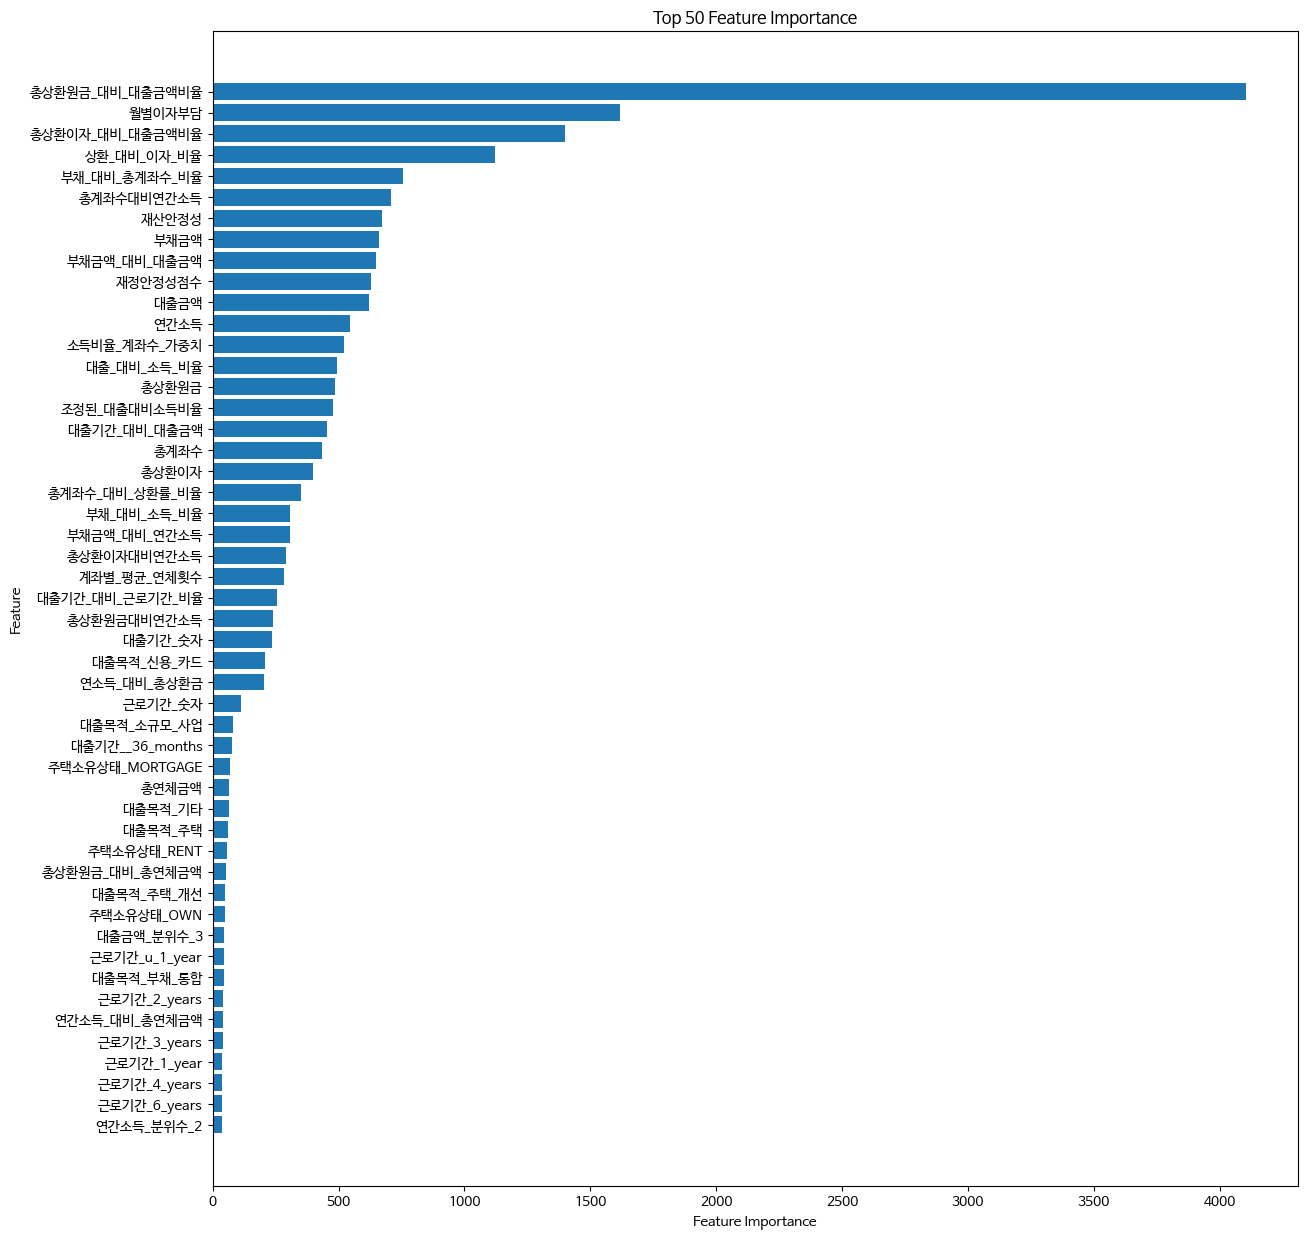

In [34]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set the font globally
plt.rcParams['font.family'] = 'NanumBarunGothic'
import matplotlib.pyplot as plt
import lightgbm as lgb



# 모델을 전체 데이터에 학습시킴
model.fit(train_ft, target)

# 피처 중요도 추출
feature_importance = model.feature_importances_

# 피처 중요도를 피처 이름과 매핑
feature_importance_dict = dict(zip(train_ft.columns, feature_importance))

# 피처 중요도를 내림차순으로 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피처 중요도를 시각화 (예: 상위 10개)
top_n = 50
top_features = sorted_feature_importance[:top_n]

# 시각화
plt.figure(figsize=(14, 15))
plt.barh(range(top_n), [x[1] for x in top_features], align='center')
plt.yticks(range(top_n), [x[0] for x in top_features])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importance'.format(top_n))
plt.gca().invert_yaxis()
plt.show()